In [69]:
#Library Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import requests
from datetime import date
from varclushi import VarClusHi
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPRegressor

In [14]:
# Raw Data Collection

# Definition of parameters for API Call
params = {
  'access_key': 'D3BD1V1XVCUGQQ2XGZIGF4F52AE2ROYH',
  'periodType' : 'year',
  'period' : '10',
  'frequencyType' : 'daily',
}

# $AAPL API Call 
api_result_aapl = requests.get('https://api.tdameritrade.com/v1/marketdata/AAPL/pricehistory?apikey=' 
                          + params['access_key'] 
                          + '&periodType='
                          + params['periodType']
                          + '&period='
                          + params['period']
                          + '&frequencyType='
                          + params['frequencyType'])

# Comparative Assets

# $GOOGL API Call
api_result_googl = requests.get('https://api.tdameritrade.com/v1/marketdata/GOOGL/pricehistory?apikey=' 
                          + params['access_key'] 
                          + '&periodType='
                          + params['periodType']
                          + '&period='
                          + params['period']
                          + '&frequencyType='
                          + params['frequencyType'])

# $MSFT API Call
api_result_msft = requests.get('https://api.tdameritrade.com/v1/marketdata/MSFT/pricehistory?apikey=' 
                          + params['access_key'] 
                          + '&periodType='
                          + params['periodType']
                          + '&period='
                          + params['period']
                          + '&frequencyType='
                          + params['frequencyType'])

# $META API Call
api_result_meta = requests.get('https://api.tdameritrade.com/v1/marketdata/META/pricehistory?apikey=' 
                          + params['access_key'] 
                          + '&periodType='
                          + params['periodType']
                          + '&period='
                          + params['period']
                          + '&frequencyType='
                          + params['frequencyType'])

# $SP500 API Call
api_result_sp500 = requests.get('https://api.tdameritrade.com/v1/marketdata/$SPX.X/pricehistory?apikey=' 
                          + params['access_key'] 
                          + '&periodType='
                          + params['periodType']
                          + '&period='
                          + params['period']
                          + '&frequencyType='
                          + params['frequencyType'])

# Convert result to DF
def json_to_df(api_result):
    json_result = api_result.json()
    raw_data = pd.DataFrame(json_result['candles'])
    return raw_data

# Pass json to pandas data frame
raw_data_aapl = json_to_df(api_result_aapl)
raw_data_googl = json_to_df(api_result_googl)
raw_data_msft = json_to_df(api_result_msft)
raw_data_meta = json_to_df(api_result_meta)

# Join data frames together, sloppy code right now... will refract in future
data_appl_googl = pd.merge(raw_data_aapl, raw_data_googl, on=['datetime'], suffixes=('_aapl', '_googl'))
data_msft_meta = pd.merge(raw_data_meta, raw_data_msft, on=['datetime'], suffixes=('_meta', '_msft'))    
data = pd.merge(data_appl_googl, data_msft_meta, on=['datetime'])

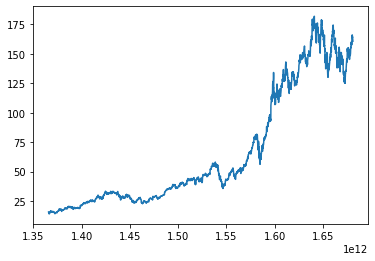

In [15]:
# Quick visualization of opening closing price over past 10 years
plt.plot(data["datetime"], data["close_aapl"])
plt.show()

In [16]:
# Check for missing data values
print(data.isnull().sum())

open_aapl       0
high_aapl       0
low_aapl        0
close_aapl      0
volume_aapl     0
datetime        0
open_googl      0
high_googl      0
low_googl       0
close_googl     0
volume_googl    0
open_meta       0
high_meta       0
low_meta        0
close_meta      0
volume_meta     0
open_msft       0
high_msft       0
low_msft        0
close_msft      0
volume_msft     0
dtype: int64


In [17]:
# Pre-process data with feature engineering to create a set of technical indicators

# Calculate relative strength index
def create_rsi(dataset, lookback):
    ret = dataset['close_aapl'].diff()
    up = ret.where(ret > 0, 0)
    down = -ret.where(ret < 0, 0)
    up_ewm = up.ewm(com=lookback-1, adjust=False).mean()
    down_ewm = down.ewm(com=lookback-1, adjust=False).mean()
    rs = up_ewm / down_ewm
    rsi = 100 - (100 / (1 + rs))
    rsi_df = pd.DataFrame({'rsi': rsi}).set_index(dataset['close_aapl'].index)
    rsi_df = rsi_df.dropna()
    return rsi_df.iloc[3:]

# Function for creating techincal indicators
def create_technical_indicators(dataset):
    # Create Simple Moving Averages
    dataset['sma7'] = dataset['close_aapl'].rolling(window=7).mean()
    dataset['sma21'] = dataset['close_aapl'].rolling(window=21).mean()
    
    # Create Simple Moving Averages Volume
    dataset['sma5_volume'] = dataset['volume_aapl'].rolling(window=5).mean()
    dataset['sma15_volume'] = dataset['volume_aapl'].rolling(window=15).mean()
    dataset['sma_volume_ratio'] = dataset['sma5_volume'] / dataset['sma15_volume']
    
    # Create Stochastic Oscillators
    dataset['lowest5'] = dataset['low_aapl'].rolling(window=5).min()
    dataset['highest5'] = dataset['high_aapl'].rolling(window=5).max()
    dataset['lowest15'] = dataset['low_aapl'].rolling(window=15).min()
    dataset['highest15'] = dataset['high_aapl'].rolling(window=15).max()

    dataset['stochastic5'] = ((dataset['close_aapl'] - dataset['lowest5']) / (dataset['highest5'] - dataset['lowest5'])) * 100
    dataset['stochastic15'] = ((dataset['close_aapl'] - dataset['lowest15']) / (dataset['highest15'] - dataset['lowest15'])) * 100

    dataset['stochastic5mean'] = dataset['stochastic5'].rolling(window = 5).mean()
    dataset['stochastic15mean'] = dataset['stochastic15'].rolling(window = 15).mean()

    dataset['stochastic_ratio'] = dataset['stochastic5mean'] / dataset['stochastic15mean']
    
    # Create Bollinger Bands
    dataset['20sd'] = dataset['close_aapl'].rolling(20).std()
    dataset['upper_band'] = dataset['sma21'] + (dataset['20sd'] * 2)
    dataset['lower_band'] = dataset['sma21'] - (dataset['20sd'] * 2)
    
    # Create Exponential moving average
    dataset['ema26'] = dataset['close_aapl'].ewm(span=26).mean()
    dataset['ema12'] = dataset['close_aapl'].ewm(span=12).mean()
    dataset['ema'] = dataset['close_aapl'].ewm(com=0.5).mean()
    
    # Create MACD
    dataset['macd'] = (dataset['ema12'] - dataset['ema26'])
    
    # Create Momentum
    dataset['momentum'] = dataset['close_aapl'] - 1
    
    # Create RSI
    dataset['rsi_5'] = create_rsi(dataset, 5)
    dataset['rsi_15'] = create_rsi(dataset, 15)
    dataset['rsi_ratio'] = dataset['rsi_5'] / dataset['rsi_15']
    
    # Create Average True Range
    dataset['tr'] = np.maximum((dataset['high_aapl'] - dataset['low_aapl']), np.maximum(abs(dataset['high_aapl'] - dataset['close_aapl'].shift(1)), abs(dataset['close_aapl'].shift(1) - dataset['low_aapl'])))
    dataset['atr'] = dataset['tr'].rolling(window = 14).mean()
    
    # Create Rate of Change
    dataset['roc'] = dataset['close_aapl'].pct_change(periods=15)
    
    return dataset

# Assign row numbers
data = data.assign(row_number=range(len(data)))

# Convert from seconds since epoch to datetime
data['datetime'] = pd.to_datetime(data['datetime'],unit='ms')

# Create technical indicators for $AAPl
data = create_technical_indicators(data)

In [18]:
# Dataset shape overview
print(data.shape)
data = data.dropna()
print(data.shape)

(2518, 50)
(2490, 50)


In [19]:
data

,open_aapl,high_aapl,low_aapl,close_aapl,volume_aapl,datetime,open_googl,high_googl,low_googl,close_googl,...,ema12,ema,macd,momentum,rsi_5,rsi_15,rsi_ratio,tr,atr,roc
28,15.648214,15.910000,15.507143,15.702143,456296960,2013-05-21 05:00:00,22.722499,22.813586,22.461997,22.696223,...,15.753152,15.704656,0.102646,14.702143,47.142558,51.506166,0.915280,0.402857,0.419107,-0.007046
29,15.858928,16.012497,15.650714,15.762643,443259432,2013-05-22 05:00:00,22.585867,22.754780,22.193486,22.257048,...,15.754622,15.743314,0.094893,14.762643,50.515683,52.505441,0.962104,0.361782,0.421224,0.004698
30,15.569643,15.934286,15.563928,15.790714,353380944,2013-05-23 05:00:00,21.946247,22.270561,21.871174,22.091137,...,15.760206,15.774914,0.089791,14.790714,52.281844,52.987045,0.986691,0.370357,0.428010,-0.007587
31,15.744643,15.916429,15.727143,15.898214,276426556,2013-05-24 05:00:00,21.902705,21.991791,21.796352,21.854158,...,15.781540,15.857114,0.092680,14.898214,59.244868,54.864917,1.079832,0.189286,0.410357,-0.010734
32,16.067857,16.111072,15.744643,15.765678,386144752,2013-05-28 05:00:00,22.108905,22.325114,22.031329,22.053100,...,15.779090,15.796157,0.084052,14.765678,48.367937,52.115124,0.928098,0.366429,0.405791,-0.041829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2513,166.595000,166.840000,165.110000,165.630000,46278295,2023-04-04 05:00:00,104.330000,105.580000,104.040000,104.720000,...,160.988903,165.543863,3.925407,164.630000,78.365334,68.962604,1.136345,1.730000,2.992864,0.085458
2514,164.740000,165.050000,161.800000,163.760000,51511744,2023-04-05 05:00:00,105.780000,106.100000,103.660000,104.470000,...,161.415226,164.354621,3.855692,162.760000,60.043137,64.039016,0.937602,3.830000,2.922150,0.070397
2515,162.430000,164.958400,162.000000,164.660000,45390123,2023-04-06 05:00:00,105.260000,109.170000,104.330000,108.420000,...,161.914422,164.558207,3.828928,163.660000,64.970339,65.315932,0.994709,2.958400,2.957750,0.056529
2516,161.420000,162.030000,160.080000,162.030000,47716882,2023-04-10 05:00:00,106.980000,107.590000,105.120000,106.440000,...,161.932203,162.872736,3.554523,161.030000,44.793688,58.780960,0.762044,4.580000,3.022750,0.045355


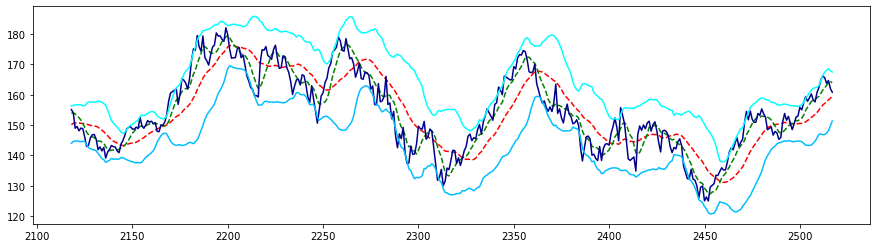

In [20]:
# Exploratory analysis of technical indicators
last400days = data.iloc[-400:]
plt.figure().set_figwidth(15)
plt.plot(last400days["row_number"], last400days["sma21"], color='red', linestyle='dashed')
plt.plot(last400days["row_number"], last400days["sma7"], color='green', linestyle='dashed')
plt.plot(last400days["row_number"], last400days["close_aapl"], color='darkblue')
plt.plot(last400days["row_number"], last400days["upper_band"], color='cyan')
plt.plot(last400days["row_number"], last400days["lower_band"], color='deepskyblue')
plt.show()

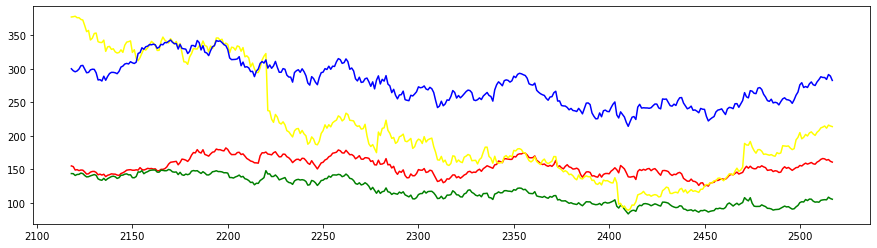

In [21]:
# Closing Price of $APPL vs comparative assets
plt.figure().set_figwidth(15)
plt.plot(last400days["row_number"], last400days["close_aapl"], color='red')
plt.plot(last400days["row_number"], last400days["close_googl"], color='green')
plt.plot(last400days["row_number"], last400days["close_meta"], color='yellow')
plt.plot(last400days["row_number"], last400days["close_msft"], color='blue')
plt.show()

In [22]:
# Export raw data to CSV file
filename = "stockdata_" + str(date.today()) + ".csv"
data.to_csv("data/" + filename, index=False)

In [26]:
# Use Varclushi for feature importance and reduction

#Drop row number columns and close_aapl price for feature correlation
feature_data = data.drop(columns='close_aapl')
feature_data = data.drop(columns='row_number')
feature_data = data.drop(columns='datetime')

data_vc = VarClusHi(feature_data, maxeigval2 = 1, maxclus = None)
data_vc.varclus()
data_vc.info

,Cluster,N_Vars,Eigval1,Eigval2,VarProp
0,0,28,26.593329,0.696829,0.949762
1,1,6,4.146973,0.992990,0.691162
2,2,4,3.998745,0.000708,0.999686
3,3,5,3.376310,0.945477,0.675262
4,4,5,3.436940,0.757663,0.687388
5,5,1,1.000000,0.000000,1.000000


In [27]:
# As demonstrated above, varclushi appears to cluster the technical/basic indicators of each individual asset together
# As such, relying on this for feature reduction does not serve as necessarily as a viable option
# We plan to review additional feature reduction methods as we begin to port the dataset into the model to determine
# what yields the best results

In [39]:
# PCA Feature Reduction
data_pca = feature_data.values
data_pca = (data_pca - data_pca.mean()) / data_pca.std()

# Fit PCA with all features
pca = PCA()
pca.fit(data_pca)

# Check explained variance ratios for each component
explained_variances = pca.explained_variance_ratio_
print(explained_variances)

[8.61440824e-01 7.90973444e-02 2.25150194e-02 1.98573696e-02
 1.12153618e-02 5.87408083e-03 1.01500058e-11 4.30015219e-13
 2.38966420e-13 9.31025814e-14 2.03684711e-14 1.38383212e-14
 7.75757703e-15 4.22583320e-15 3.45561124e-15 1.58657639e-15
 6.35447087e-16 4.14076880e-16 3.45945289e-16 2.25288729e-16
 1.01221170e-16 8.51585850e-17 5.98409286e-17 5.81133669e-17
 4.19205154e-17 3.13530787e-17 2.77742680e-17 2.47493391e-17
 1.90666617e-17 1.62723746e-17 1.39235334e-17 7.88916827e-18
 7.18890178e-18 6.44368871e-18 3.52890901e-18 3.49466387e-18
 2.75792441e-18 2.45834043e-18 1.75870206e-18 1.30488788e-18
 1.19112818e-18 7.07880174e-19 2.13690184e-19 8.05369633e-20
 2.33394178e-20 5.97899682e-33 5.97899682e-33 5.97899682e-33
 5.97899682e-33]


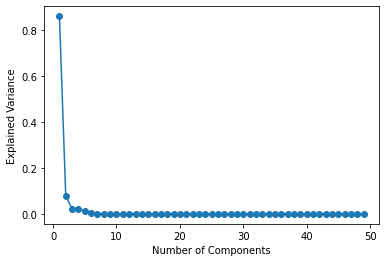

In [40]:
# Visualize explained variance ratios
import matplotlib.pyplot as plt
plt.plot(range(1, 50), explained_variances, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.show()

In [41]:
# The plot above demonstrates our first component explains > 80% of the result, as such
# it seems that 

In [ ]:
# Given the results from above, we shift our focus to autoencoding features then attempting to feature engineer the resulting variables

In [66]:
# Attempt at autoencoding, not working how I intended

# # Encode categorical features

# #Drop row number columns and close_aapl price for feature correlation
# feature_data_encoding = data.drop(columns='row_number')
# feature_data_encoding = data.drop(columns='datetime')

# # Split the data into features and target
# X = feature_data_encoding.drop('close_aapl', axis=1)
# y = feature_data_encoding['close_aapl']

# # Define the autoencoder model
# model = MLPRegressor(hidden_layer_sizes=(10, 5, 2, 5, 10), activation='relu', solver='adam', max_iter=1000)

# # Fit the model to the data
# model.fit(X, X)

# # Encode the features using the autoencoder model
# X_auto = model.predict(X)

# # Create a new dataframe with the encoded features and target
# X_auto


array([[ -86098.98203139,   -5523.76752898, -123342.93041835, ...,
         151336.25509276,  -79272.51436175,  111453.86731995],
       [ -82294.18524578,   -5279.67319644, -117892.3171094 , ...,
         144648.60156568,  -75769.39534266,  106528.62767201],
       [ -73437.15934309,   -4711.45629871, -105204.06436342, ...,
         129080.69508995,  -67614.63238406,   95063.37010457],
       ...,
       [ -10625.77295964,    -681.83151217,  -15222.75974559, ...,
          18677.74498316,   -9783.48537314,   13755.18257448],
       [  -9768.0455827 ,    -626.80455452,  -13994.01074279, ...,
          17170.12609025,   -8993.76616955,   12644.87021824],
       [  -9584.85277829,    -615.05193596,  -13731.57540285, ...,
          16848.1299171 ,   -8825.09850253,   12407.73049322]])